In [1]:
import os

In [2]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm
import optuna
from lightfm import LightFM
import dill
from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [5]:
DATA_PATH = Path("kion_train")

# LOAD DATA 

In [6]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: total: 6.12 s
Wall time: 6.62 s


# Preprocess

In [7]:
Columns.Datetime = 'last_watch_dt'

In [8]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [9]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [10]:
max_date = interactions[Columns.Datetime].max()

In [11]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [12]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [13]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [14]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [15]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# Применим optuna.

In [16]:
# Количество рекомендаций, воспроизводимость, количество запусков. 

k = 10
random_state = 42
n_trials = 12

In [17]:
# В качестве метрики используем MAP

metric = MAP(k = 10)
dataset = Dataset.construct(interactions_df=train)

In [18]:
# В качестве параметров для перебора возьмём следующие:
# factors - число факторов.
# regularization - регуляризация
# iterations - количество итераций во время обучения

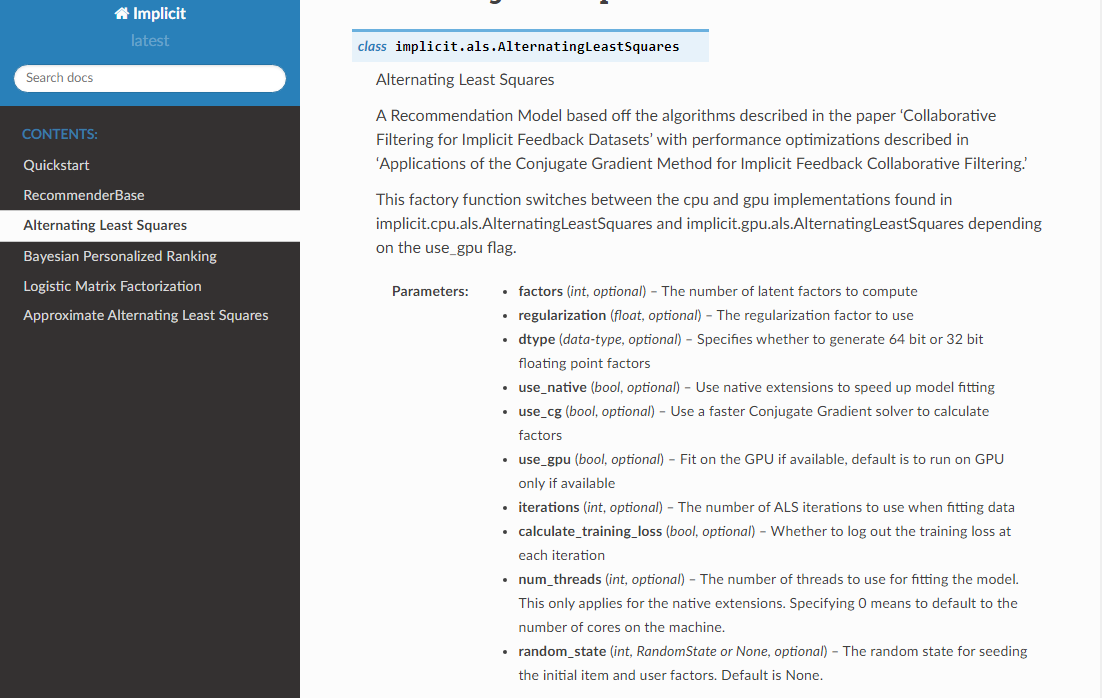

In [19]:
# Функция для запуска optuna по перебору параметров. 
# Так как считается очень долго, то придётся указываать не очень широкие диапазоны для параметров. 

def optuna_objective(trial):
    
    factors = trial.suggest_int('factors', 4, 8)
    regularization = trial.suggest_float('regularization', 2e-4, 0.9)
    iterations = trial.suggest_int('iterations', 20, 80)
    
    als = ImplicitALSWrapperModel(model = AlternatingLeastSquares(
                                                                 factors = factors,
                                                                 regularization = regularization,
                                                                 iterations = iterations,
                                                                 use_native = True, 
                                                                 use_cg = True,
                                                                 use_gpu = False,
                                                                 random_state = random_state
                                                                 )) 
    
    als.fit(dataset)
    
    recos = als.recommend(users=test[Columns.User].unique(), dataset=dataset, k=k, filter_viewed=True)
       
    map10 = metric.calc_per_user(recos, test)
    
    return map10.mean()

In [20]:
# Запустим перебор параметров через optuna.

study = optuna.create_study(directions = ['maximize'])
study.optimize(optuna_objective, n_trials=n_trials)

[I 2022-12-09 02:56:40,485] A new study created in memory with name: no-name-eaecc203-fc44-4c03-808c-a24d9e496d4e
[I 2022-12-09 03:00:11,320] Trial 0 finished with value: 0.055608691621716895 and parameters: {'factors': 6, 'regularization': 0.6648613556648364, 'iterations': 60}. Best is trial 0 with value: 0.055608691621716895.
[I 2022-12-09 03:03:51,491] Trial 1 finished with value: 0.055632974223557674 and parameters: {'factors': 6, 'regularization': 0.5009937843278507, 'iterations': 80}. Best is trial 1 with value: 0.055632974223557674.
[I 2022-12-09 03:06:50,348] Trial 2 finished with value: 0.05144814989742937 and parameters: {'factors': 7, 'regularization': 0.06813198184132731, 'iterations': 55}. Best is trial 1 with value: 0.055632974223557674.
[I 2022-12-09 03:10:02,787] Trial 3 finished with value: 0.04662239001372444 and parameters: {'factors': 8, 'regularization': 0.5605788256840125, 'iterations': 73}. Best is trial 1 with value: 0.055632974223557674.
[I 2022-12-09 03:13:39,

In [21]:
# Посмотрим на лучшие параметры, найденные optuna.

study.best_params

{'factors': 5, 'regularization': 0.38878772157042235, 'iterations': 80}

In [23]:
# Теперь обучим модель на всех данных. Используем лучшие параметры, найденные optuna.

all_dataset = Dataset.construct(interactions_df=interactions)

final_als = ImplicitALSWrapperModel(model = AlternatingLeastSquares(
                                   factors = study.best_params['factors'],
                                   regularization = study.best_params['regularization'],
                                   iterations = study.best_params['iterations'],
                                   use_native = True,
                                   use_cg = True,
                                   use_gpu = False,
                                   random_state = random_state
                                   ))

final_als.fit(all_dataset)

In [25]:
# Сохраним нашу модель.

with open('als.dill', 'wb') as f:
    dill.dump(final_als, f)

In [26]:
# Проверим, что модель выдает рекомендации. Возьмём user_id = 10347 

final_als.recommend(pd.DataFrame([10347])[0], all_dataset, k=10, filter_viewed = True)

,user_id,item_id,score,rank
0,10347,15297,0.122930,1
1,10347,4151,0.117207,2
2,10347,16166,0.072350,3
3,10347,7626,0.069180,4
4,10347,12173,0.069000,5
5,10347,3182,0.067905,6
6,10347,13018,0.066925,7
7,10347,14317,0.061130,8
8,10347,1844,0.059379,9
9,10347,14431,0.057074,10
